In [1]:
# Kernel dl
# Initial code and auxiliar functions. Don't pay attention to this
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
# pip install untangle
# The easiest way to parse xml files I have found.
import untangle

In [3]:
# dlib image object detection dataset xml file format
basepath='/home/francisco/Pictures/datasets/indoor_object_detection_dataset/faster_bounding_box_dataset/all'
filename='exit_fire.xml'
obj=untangle.parse(filename)
len(obj.dataset.images.image)

1086

In [4]:
def fillRec(img,x,y,w,h):
    for i in range(w):
        for j in range(h):
            img[y+j,x+i,0]=1
            
def setCenter(img,top,left,width,height):
    center_x=left+width//2
    center_y=top +height//2
    y[center_y,center_x,0]=1
    
images=[]
labels=[]
scale=4
reduction=8
for i in obj.dataset.images.image[:]:
    imgfile=os.path.join(basepath,i['file'])
    img=cv2.imread(imgfile)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize and 
    # normalize very important!!
    img=cv2.resize(img, (img.shape[1]//scale, img.shape[0]//scale))/255.0
    #print(i['file'],'\t',img.shape)
    height_i=img.shape[0]
    width_i =img.shape[1]
    height_o=height_i//reduction
    width_o =width_i //reduction
    y=np.zeros((height_o,width_o,1))
    for b in i.box:
        top   =int(b['top'   ])//scale//reduction
        left  =int(b['left'  ])//scale//reduction
        width =int(b['width' ])//scale//reduction
        height=int(b['height'])//scale//reduction
        
        #setCenter(y,top,left,width,height)
        fillRec(y,left,top,width,height)
        #print("  ",b.label.cdata,"\t->\t[",top,",",left,",",width,",",height,"]")
    images.append(img)
    labels.append(y)
    

(1086, 180, 320, 3)
(180, 320, 3)
(986, 180, 320, 3)
(986, 22, 40, 1)
(100, 180, 320, 3)
(100, 22, 40, 1)
0.0 1.0


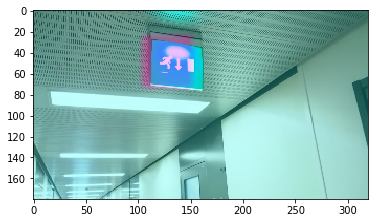

In [15]:
images_np=np.array(images)
y_train=np.array(labels[:-100])
y_test =np.array(labels[:100])
print(images_np.shape)
x_train=images_np[:-100]
x_test =images_np[:100]

idx=random.randint(0,y_train.shape[0])
print(x_train[idx].shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(np.min(y_train),np.max(y_train))
plt.figure()
plt.imshow(x_train[idx].reshape(height_i,width_i,3))
#plt.show()
img_np=y_train[idx].reshape(height_o,width_o)
img=cv2.resize(img_np,(width_i,height_i))
plt.imshow(img,cmap='cool',alpha=0.25)
plt.show()

In [6]:
# keras 1.2.2
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [7]:
#input_shape=(360,640,3)
# Dynamic Imput size
input_shape=(None,None,3)
model = Sequential()

# Without BatchNormalization the model doesn't seem to learn
# (11/04/2019) actually I hadn't normalized the color images just I had to divide by 255
# (11/04/2019) with dropouts and without BatchNorm learn but slowly
model.add(Conv2D(32, 5,5,border_mode='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Conv2D(32, 3, 3,border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Conv2D(32, 3, 3,border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

# receptive field aproximation 8(reduction)x3(convolution size)=24
#model.add(Conv2D(1, 3, 3, activation='sigmoid',border_mode='same'))
# receptive field aproximation 8(reduction)x5(convolution size)=40
model.add(Conv2D(32, 5, 5,border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())

# Last layer n filters = n outputs
model.add(Conv2D(1, 3, 3, activation='sigmoid',border_mode='same'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, None, None, 32 2432        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, None, None, 32 128         convolution2d_1[0][0]            
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, None, None, 32 0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, None, None, 32 0           leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [9]:
batch_size=100
epochs=250
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[x_test,y_test],
                    verbose=1)

Train on 986 samples, validate on 986 samples
Epoch 1/250
986/986 [==============================] - 11s - loss: 0.4538 - acc: 0.8492 - val_loss: 0.5063 - val_acc: 0.9736
Epoch 2/250
986/986 [==============================] - 9s - loss: 0.2017 - acc: 0.9773 - val_loss: 0.2948 - val_acc: 0.9738

In [16]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.00280924269299
Train accuracy: 0.999060130385
Test loss: 0.0025410943781
Test accuracy: 0.999101715088


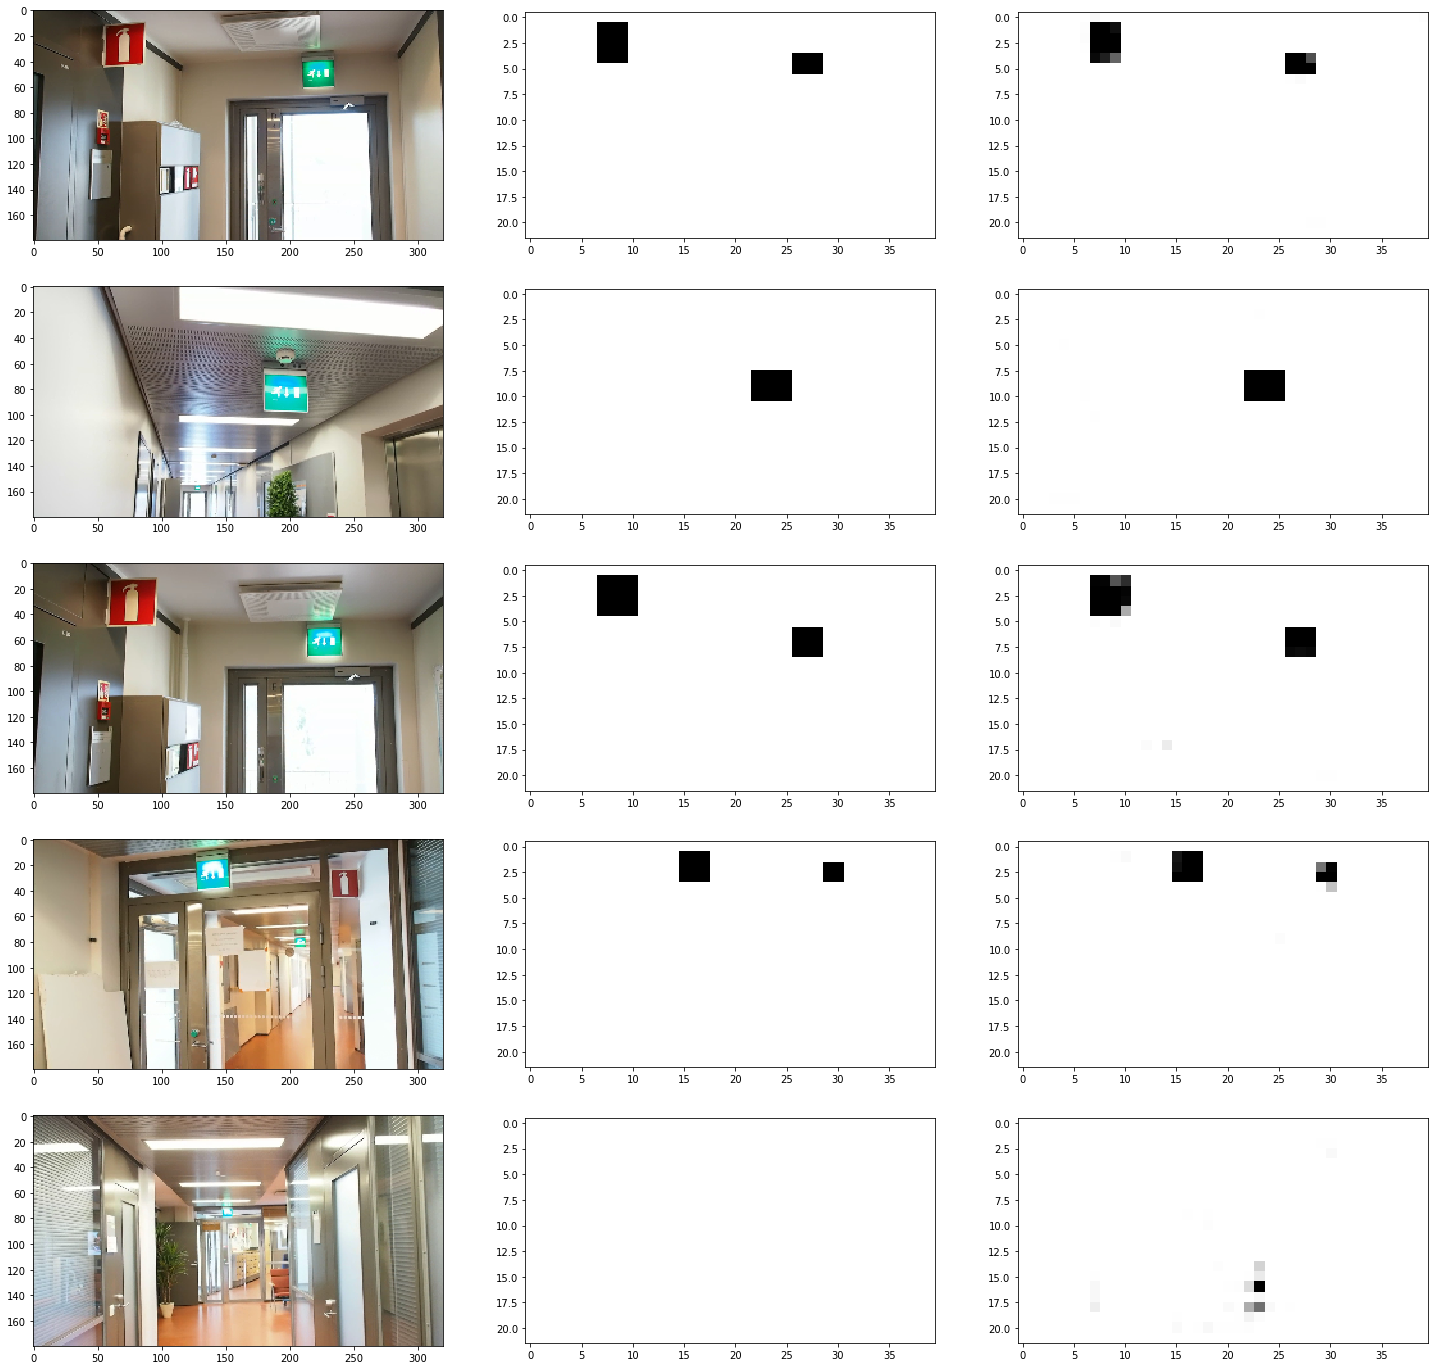

In [24]:
plt.figure(1,figsize=(25,50))
y_pred=model.predict(x_train)
y_dif=np.abs(y_pred-y_train)
for i in range(5):
    idx=random.randint(0,x_train.shape[0])
    #print(np.max(y_pred[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_train[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    plt.imshow(y_train[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    plt.imshow(y_pred[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
    #plt.imshow(y_dif[idx].reshape(height_o,width_o),cmap="gray_r")
plt.show()

TEST
(100, 180, 320, 3)
1.0
0.946729
0.996618
1.0
0.999998


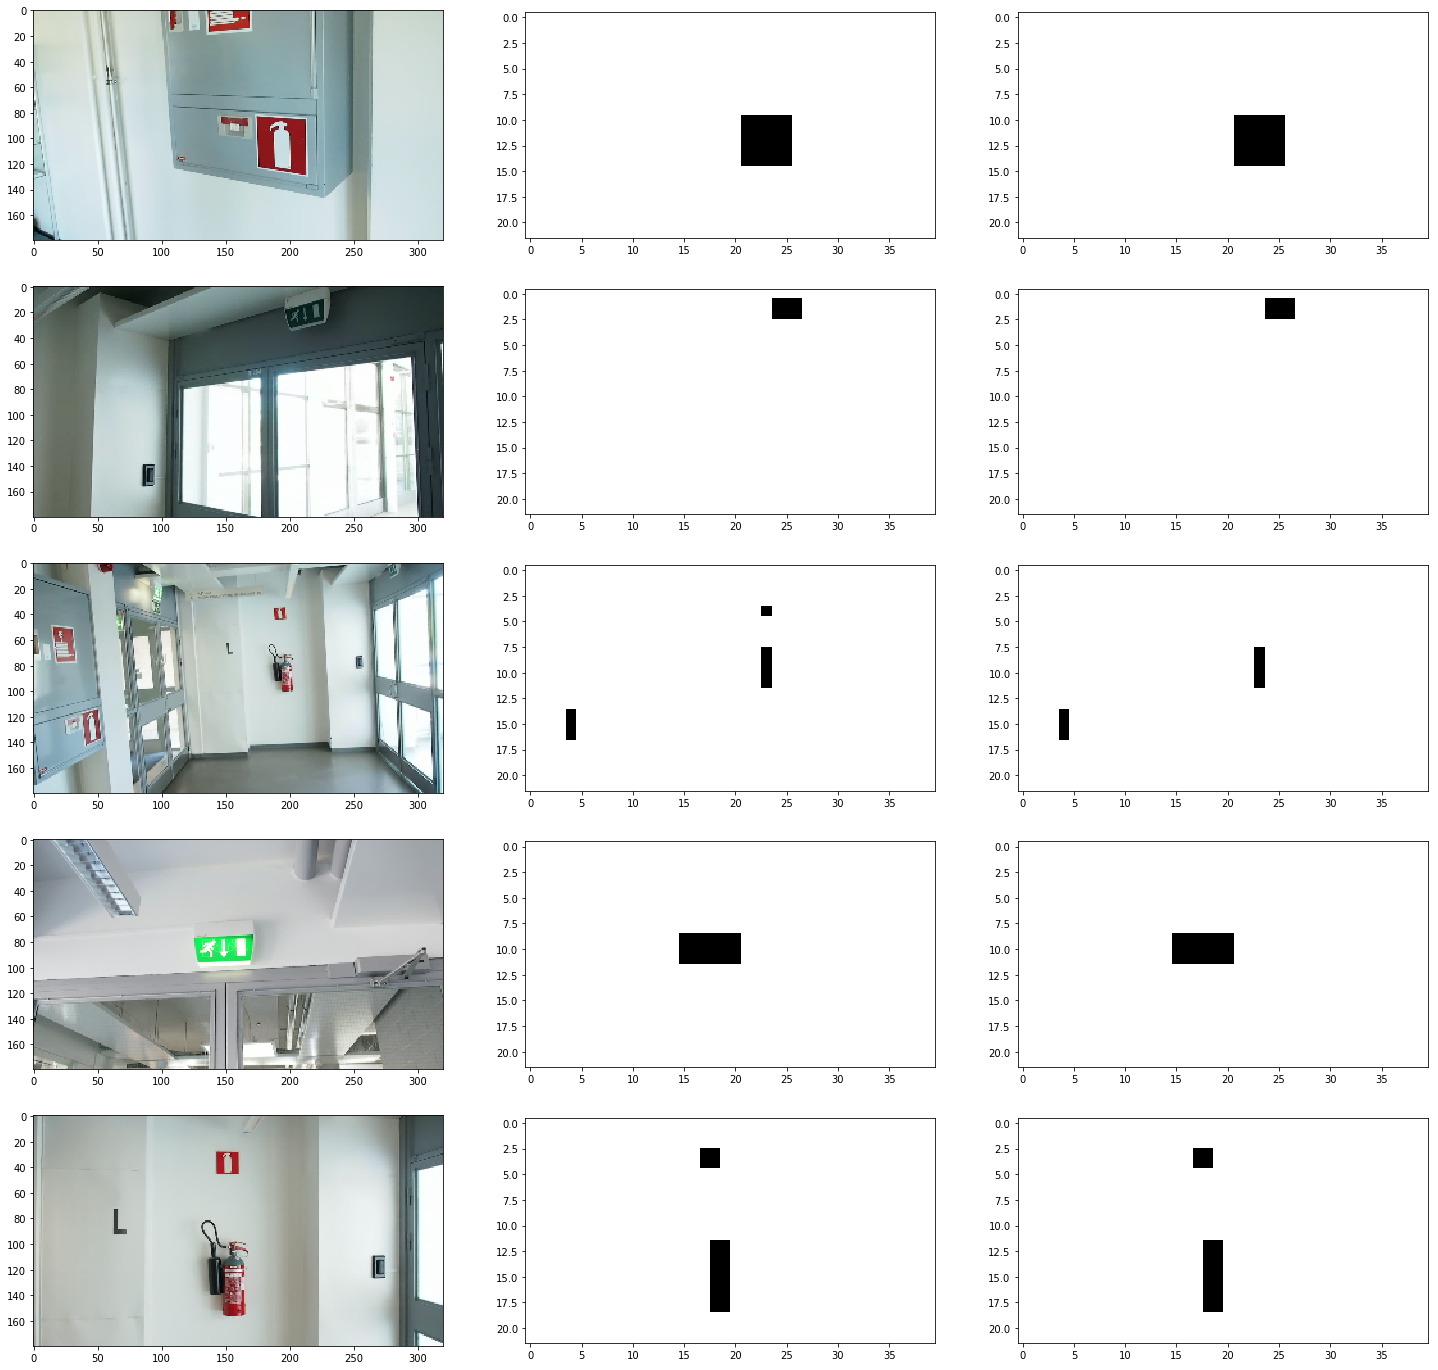

In [25]:
print("TEST")
print(x_test.shape)
plt.figure(1,figsize=(25,50))
y_predf=model.predict(x_test)
y_pred=y_predf>0.5
y_dif=np.abs(y_pred-y_test)
for i in range(5):
    idx=random.randint(0,x_test.shape[0])
    print(np.max(y_predf[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_test[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    plt.imshow(y_test[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    plt.imshow(y_pred[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
    #plt.imshow(y_dif[idx].reshape(height_o,width_o),cmap="gray_r")
    #plt.show()
plt.show()

(720, 1280, 3)
(1, 90, 160, 1)
(503, 896, 3)
(1, 62, 112, 1)
(352, 627, 3)
(1, 44, 78, 1)
(246, 438, 3)
(1, 30, 54, 1)
(172, 306, 3)
(1, 21, 38, 1)
(120, 214, 3)
(1, 15, 26, 1)


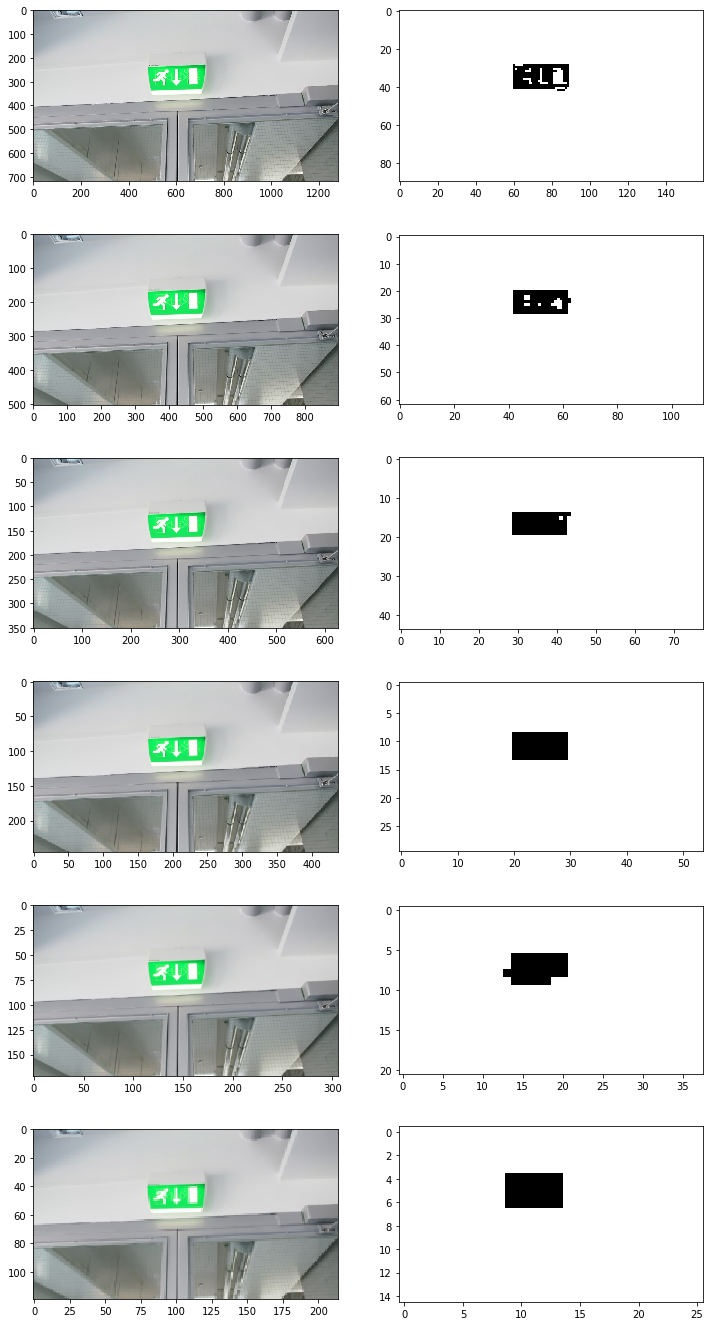

In [94]:
idx=random.randint(0,x_test.shape[0])
i=obj.dataset.images.image[idx]
imgfile=os.path.join(basepath,i['file'])
img=cv2.imread(imgfile)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255
plt.figure(1,figsize=(12,24))
for i in range(0,6):
    print(img.shape)
    plt.subplot(6, 2, i*2+1)
    plt.imshow(img)
    y_predf=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
    print(y_predf.shape)
    plt.subplot(6, 2, i*2+2)
    plt.imshow(y_predf[0].reshape(y_predf.shape[1],y_predf.shape[2])>0.5,cmap="gray_r")
    #img=cv2.pyrDown(img,(0.8,0.8))
    img=cv2.resize(img,(int(img.shape[1]*0.7),int(img.shape[0]*0.7)))
plt.show()

In [77]:
y_predf=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
print(y_predf.shape)

(1, 11, 20, 1)


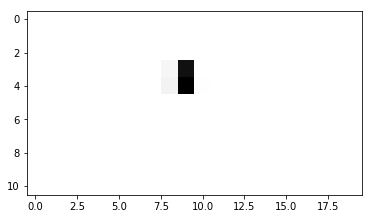

In [78]:
plt.imshow(y_predf[0].reshape(y_predf.shape[1],y_predf.shape[2]),cmap="gray_r")
plt.show()